# Rad-IA: tratamiento de datos y metodologia de funcionamiento
Para los medicos, una IA que ayude a detectar diferentes enfermedades y fracturas usando radiografias es muy util, dado que acorta el tiempo de diagnostico y permite una ejecucion de un tratamiento mas rapida, para poder ayudar a esto, es necesario comprender algunos conceptos y metodos que se van a usar para facilitar y mejorar el funcionamiento de esta herramienta.

Primero, es importante saber que el cuerpo humano cuenta con 206 huesos, para poder clasificar de mejor manera la region de la radiografia a analizar es necesario segmentar el cuerpo humano en 2 secciones muy importantes, el tronco central, y las extremidades.

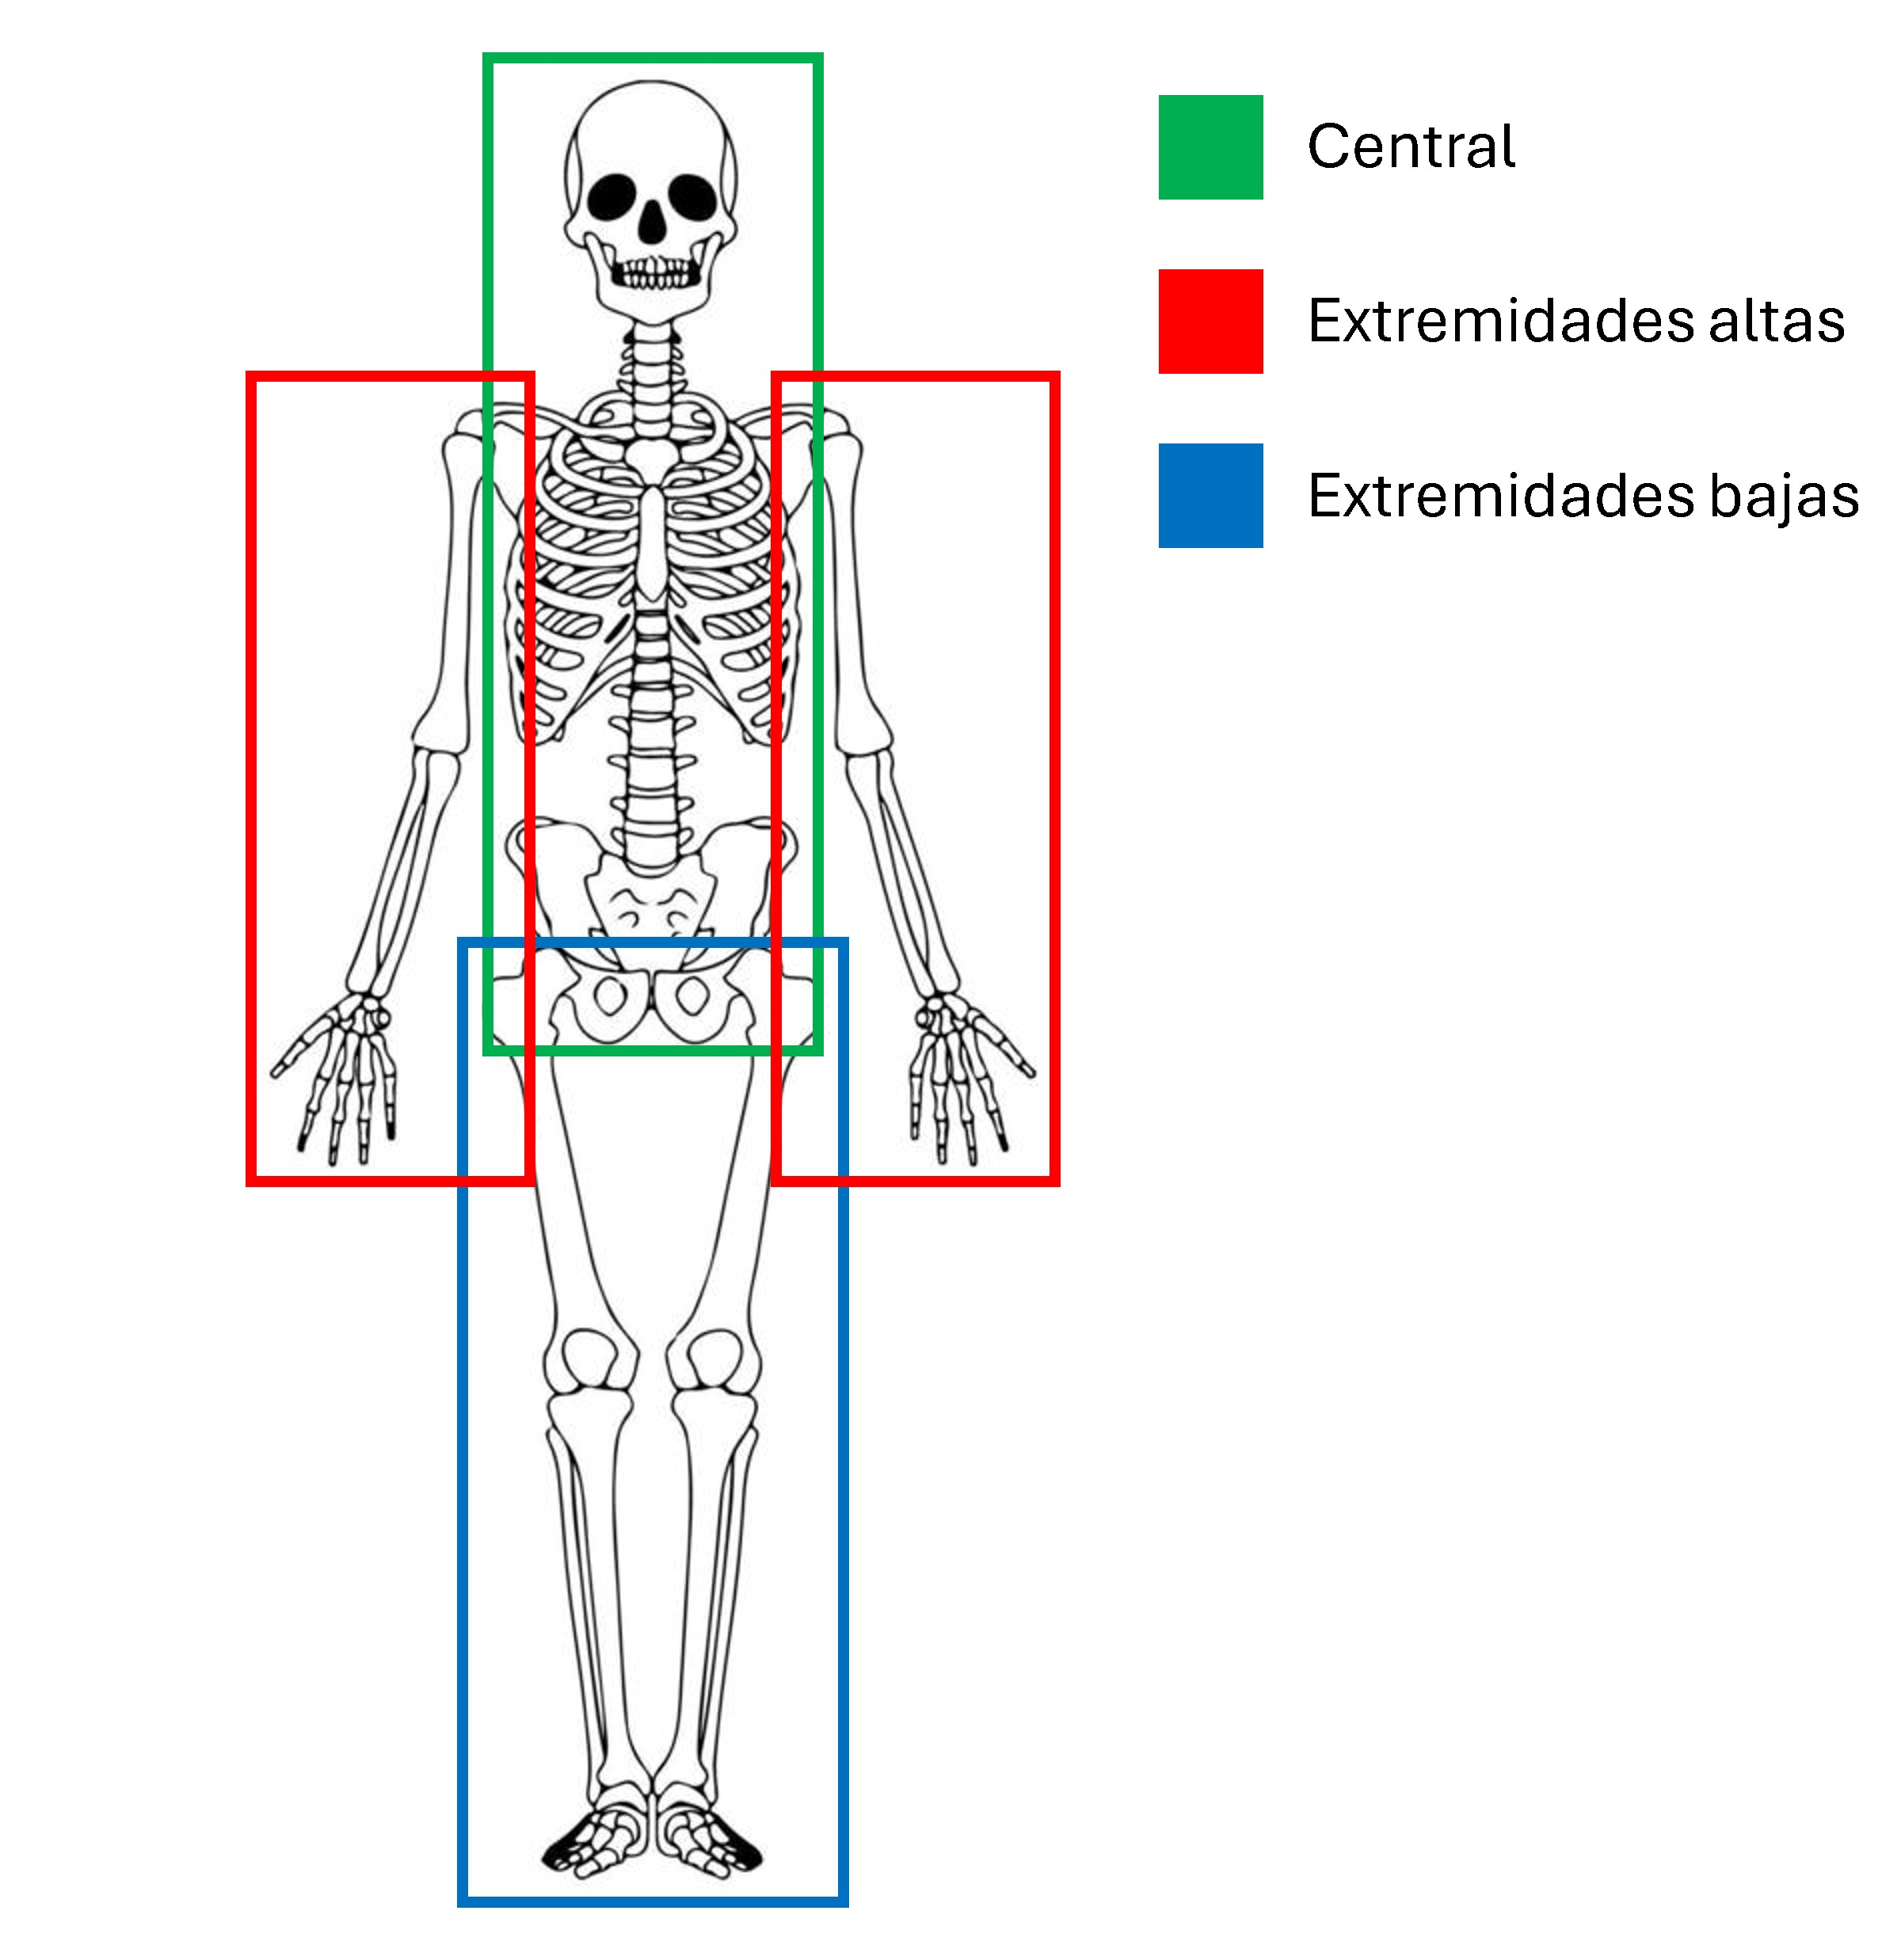

para seccionar estas areas y ser mas especifico, es posible segmentar cada una de estas en areas mas reducidas.

Para el caso del tronco central, es posible dividirlo en [Cabeza, Pecho, Pelvis].

Para el caso de las extremidades altas, es posible dividirlas en [Hombro, Codo,Mano].

Para el caso de las extremidades bajas, es posible dividirlas en [Femur, Rodilla, Perone, Pie]

Por lo que, el primer paso, es cargar la informacion con sus respectivas clasificaciones

In [ ]:
!pip install tensorflow
!pip install keras

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
# Cargar modelos
main_model = load_model("/content/drive/MyDrive/Main.keras")
central_model = load_model("/content/drive/My Drive/Central.keras")
alta_model = load_model("/content/drive/My Drive/Alta.keras")
baja_model = load_model("/content/drive/My Drive/Baja.keras")
altas_fracture_model = load_model("/content/drive/My Drive/AltasFracture.keras")
bajas_fracture_model = load_model("/content/drive/My Drive/BajasFracture.keras")
hip_fracture_model = load_model("/content/drive/My Drive/HipFracture.keras")
chest_disease_model = load_model("/content/drive/My Drive/ChestDisease.keras")
print("Modelos cargados correctamente.")

In [ ]:
# Clases
main_classes = ["Tronco central", "Extremidades altas", "Extremidades bajas"]
central_classes = ["Pecho", "Pelvis"]
alta_classes = ["Hombro", "Codo", "Mano"]
baja_classes = ["Coxis-Femoral", "Rodilla", "Pie"]
fracture_classes = ["Normal", "Fractura"]
chest_classes = [
    "Absceso", "ARDS", "Atelectasia", "Aterosclerosis de la aorta",
    "Cardiomegalia", "Enfisema", "Fractura", "Hidroneumotórax",
    "Hidrotórax", "Neumonía", "Neumoesclerosis", "Cambios postinflamatorios",
    "Deformación postraumática de costillas", "Sarcoidosis", "Escoliosis",
    "Tuberculosis", "Congestión venosa", "Normal"
]


In [ ]:
def preprocess_image(image_path):
    # Cargar imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar
    img = cv2.resize(img, (320, 320))
    # Normalización (0-1)
    img = img / 255.0
    # Invertir si el fondo es más claro que el objeto
    if np.mean(img) > 0.5:
        img = 1 - img
    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img = clahe.apply((img * 255).astype(np.uint8)) / 255.0
    # Corrección gamma (ajusta el brillo de la imagen)
    gamma = 0.8  # Ajusta este valor según la calidad de las imágenes
    img = np.power(img, gamma)

    return img

In [ ]:
def preprocess_image_HD(image_path):
    # Cargar imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar
    img = cv2.resize(img, (1024, 1024))
    # Normalización (0-1)
    img = img / 255.0
    # Invertir si el fondo es más claro que el objeto
    if np.mean(img) > 0.5:
        img = 1 - img
    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img = clahe.apply((img * 255).astype(np.uint8)) / 255.0
    # Corrección gamma (ajusta el brillo de la imagen)
    gamma = 0.8  # Ajusta este valor según la calidad de las imágenes
    img = np.power(img, gamma)

    return img

In [ ]:
# Función de predicción con severidad continua
def predict_with_severity(model, img, class_labels):
    predictions = model.predict(img)  # Se asume que devuelve dos salidas
    class_pred = np.argmax(predictions[0])  # Categoría principal
    severity_pred = float(predictions[1][0])  # Severidad como valor continuo
    return class_labels[class_pred], severity_pred

In [ ]:
# Función para extraer características del modelo (por ejemplo, capa densa previa a la salida)
def extract_features(model, img):
    # Obtenemos las características de la capa densa
    feature_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)
    features = feature_layer_model.predict(img)  # Extrae las características
    return features.flatten()  # Aplanamos el vector de características


In [ ]:
# Función de agrupación con K-means
def cluster_images(image_paths, model, n_clusters=3):
    features_list = []

    for image_path in image_paths:
        img_original, img = preprocess_image(image_path)
        features = extract_features(model, img)  # Extraemos características
        features_list.append(features)

    features_array = np.array(features_list)

    # Aplicar K-means para agrupar imágenes
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_array)

    # Asignar etiquetas de clusters a cada imagen
    cluster_labels = kmeans.labels_

    return cluster_labels, kmeans.cluster_centers_

In [ ]:
# Función para visualizar las imágenes agrupadas
def visualize_clusters(image_paths, cluster_labels):
    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(5, 5, i+1)  # Ajustar el tamaño de la cuadrícula según el número de imágenes
        plt.imshow(img, cmap="gray")
        plt.title(f"Cluster {cluster_labels[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Predicción
# Ruta de prueba
image_path = "/content/drive/My Drive/imagen_prueba.jpg"
img = preprocess_image(image_path)
imgHD = preprocess_image_HD(image_path)
# Main.keras
main_pred = main_model.predict(img)
main_class = np.argmax(main_pred)
main_label = main_classes[main_class]
print(f"Primera clasificación: {main_label}")
if main_label == "Tronco central":
    sub_label, _ = predict_with_severity(central_model, img, central_classes)
    print(f"Sub-clasificación: {sub_label}")

    if sub_label == "Pecho":
        disease_label, severity = predict_with_severity(chest_disease_model, imgHD, chest_classes)
        print(f"Diagnóstico torácico: {disease_label} | Severidad: {severity:.2f}")
    else:
        fracture_label, severity = predict_with_severity(hip_fracture_model, imgHD, fracture_classes)
        print(f"Diagnóstico de fractura: {fracture_label} | Severidad: {severity:.2f}")

elif main_label == "Extremidades altas":
    sub_label, _ = predict_with_severity(alta_model, img, alta_classes)
    print(f"Sub-clasificación: {sub_label}")

    fracture_label, severity = predict_with_severity(altas_fracture_model, imgHD, fracture_classes)
    print(f"Diagnóstico de fractura: {fracture_label} | Severidad: {severity:.2f}")

elif main_label == "Extremidades bajas":
    sub_label, _ = predict_with_severity(baja_model, img, baja_classes)
    print(f"Sub-clasificación: {sub_label}")
    fracture_label, severity = predict_with_severity(bajas_fracture_model, imgHD, fracture_classes)
    print(f"Diagnóstico de fractura: {fracture_label} | Severidad: {severity:.2f}")

# **Mostrar imagen con el resultado**
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# Agrupación
image_paths = ["/content/drive/My Drive/imagen_prueba1.jpg", "/content/drive/My Drive/imagen_prueba2.jpg", "/content/drive/My Drive/imagen_prueba3.jpg"]
cluster_labels, cluster_centers = cluster_images(image_paths, main_model, n_clusters=3)
print(f"Etiquetas de los clusters: {cluster_labels}")

# Visualizar las imágenes agrupadas
visualize_clusters(image_paths, cluster_labels)


Iguales: 4350/5000 = 87.00%


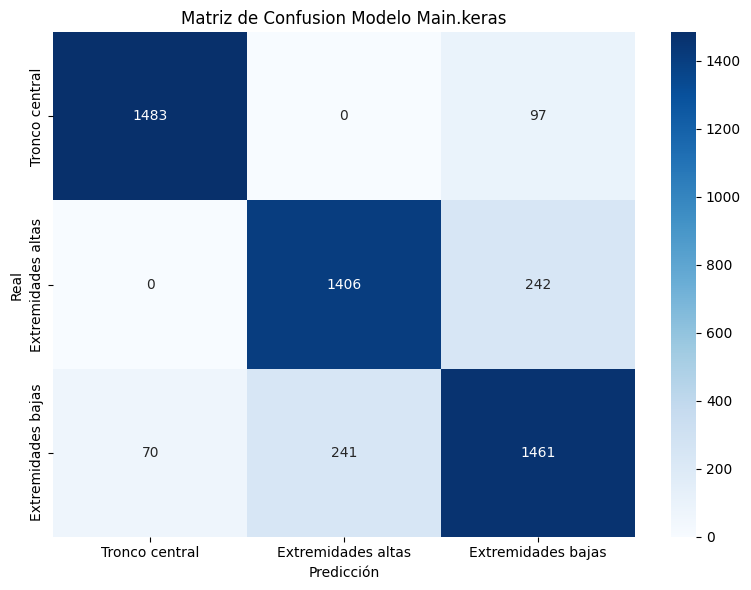

In [2]:
df = pd.read_csv('/content/drive/My Drive/Main.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(1, 5001):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(main_model.predict(np.array(preprocess_image(path))))
y_pred = np.argmax(preds, axis=1)
y_true = df['clase'].values
labels = ["Tronco central", "Extremidades altas", "Extremidades bajas"]

# Verificación
same = np.sum(y_pred == y_true)
print(f"Iguales: {same}/{5000} = {same/5000:.2%}")
# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion Modelo Main.keras')
plt.tight_layout()
plt.show()

Iguales: 1789/1945 = 91.98%


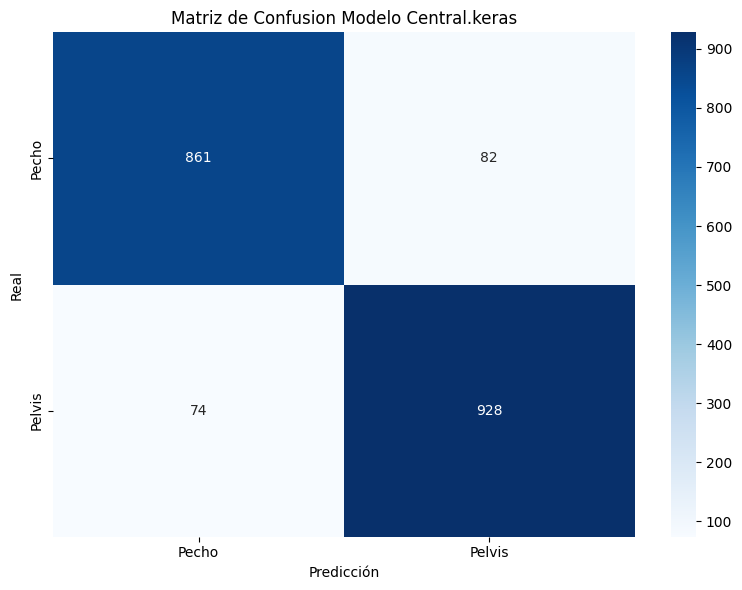

In [3]:
df = pd.read_csv('/content/drive/My Drive/Central.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(1, 1946):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(central_model.predict(np.array(preprocess_image(path))))
y_pred = np.argmax(preds, axis=1)
y_true = df['clase'].values
labels = ["Pecho","Pelvis"]
# Verificación
same = np.sum(y_pred == y_true)
print(f"Iguales: {same}/{1945} = {same/1945:.2%}")

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion Modelo Central.keras')
plt.tight_layout()
plt.show()

Iguales: 1426/1603 = 88.96%


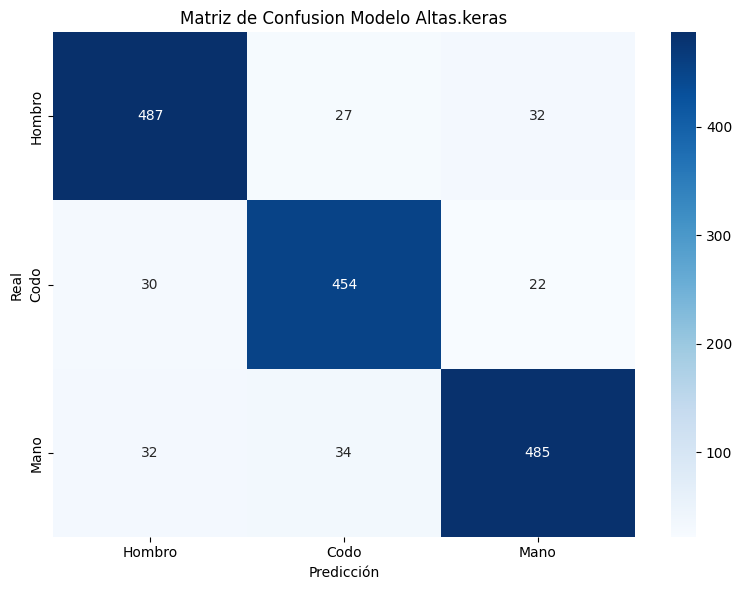

In [7]:
df = pd.read_csv('/content/drive/My Drive/Altas.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(1946, 3549):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(alta_model.predict(np.array(preprocess_image(path))))
y_pred = np.argmax(preds, axis=1)
y_true = df['clase'].values
labels = ["Hombro","Codo","Mano"]
# Verificación
same = np.sum(y_pred == y_true)
print(f"Iguales: {same}/{1603} = {same/1603:.2%}")

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion Modelo Altas.keras')
plt.tight_layout()
plt.show()

Iguales: 1234/1452 = 84.99%


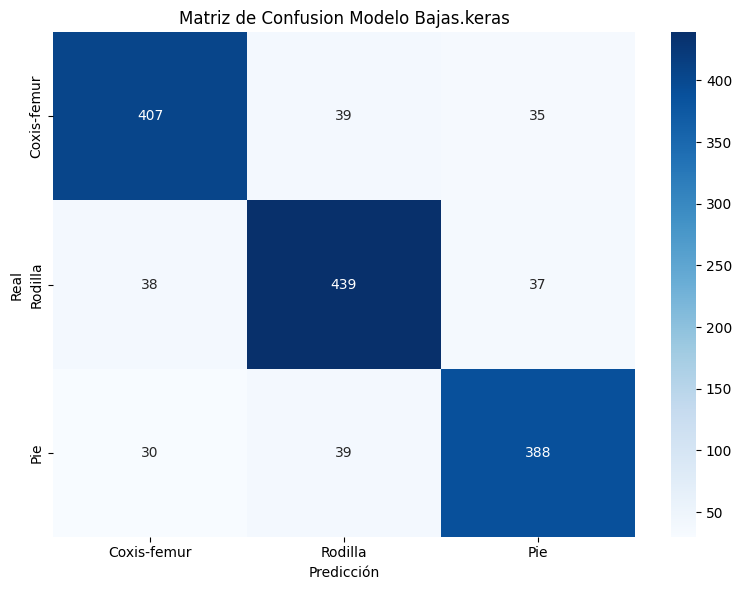

In [8]:
df = pd.read_csv('/content/drive/My Drive/Bajas.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(3549, 5001):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(baja_model.predict(np.array(preprocess_image(path))))
y_pred = np.argmax(preds, axis=1)
y_true = df['clase'].values
labels = ["Coxis-femur","Rodilla","Pie"]
# Verificación
same = np.sum(y_pred == y_true)
print(f"Iguales: {same}/{1452} = {same/1452:.2%}")

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion Modelo Bajas.keras')
plt.tight_layout()
plt.show()

Iguales: 758/972 = 77.98%


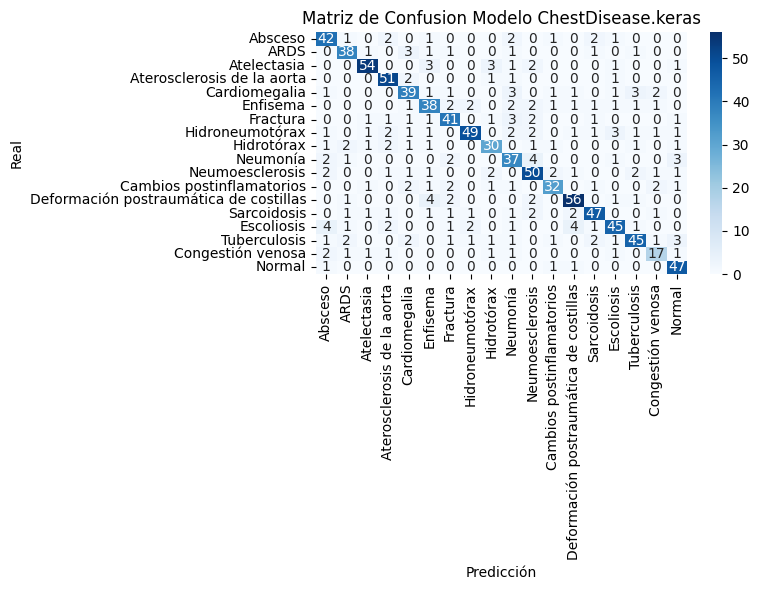

In [14]:
df = pd.read_csv('/content/drive/My Drive/Pecho.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(1, 973):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(chest_disease_model.predict(np.array(preprocess_image_HD(path)))[0])
y_pred = np.argmax(preds, axis=1)
y_true = df['clase'].values
labels = [
    "Absceso", "ARDS", "Atelectasia", "Aterosclerosis de la aorta",
    "Cardiomegalia", "Enfisema", "Fractura", "Hidroneumotórax",
    "Hidrotórax", "Neumonía", "Neumoesclerosis", "Cambios postinflamatorios",
    "Deformación postraumática de costillas", "Sarcoidosis", "Escoliosis",
    "Tuberculosis", "Congestión venosa", "Normal"
]
# Verificación
same = np.sum(y_pred == y_true)
print(f"Iguales: {same}/{972} = {same/972:.2%}")

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion Modelo ChestDisease.keras')
plt.tight_layout()
plt.show()

Iguales: 2597/3056 = 84.98%


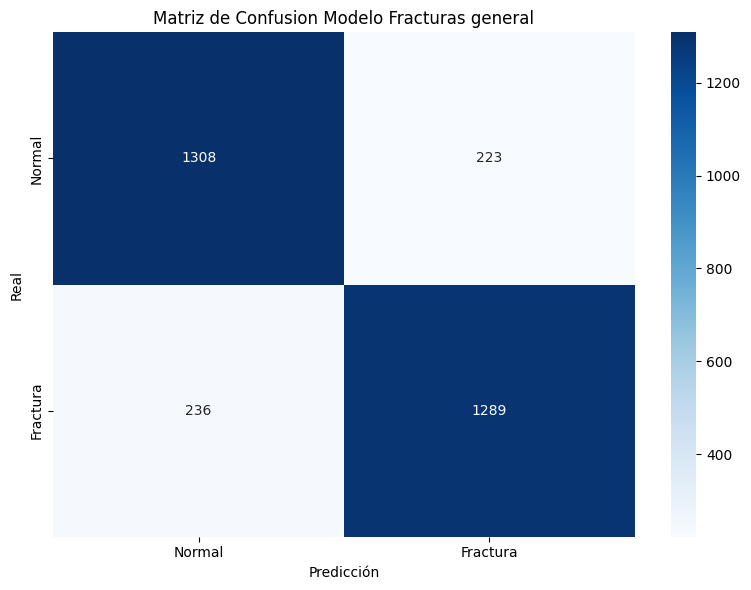

In [11]:
y_true=[]
y_pred=[]
df = pd.read_csv('/content/drive/My Drive/FracPelvis.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(973, 1946):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(hip_fracture_model.predict(np.array(preprocess_image_HD(path)))[0])
y_pred1 = np.argmax(preds, axis=1)
y_true1 = df['clase'].values
y_true.extend(y_true1)
y_pred.extend(y_pred1)

df = pd.read_csv('/content/drive/My Drive/FracAltas.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(1946, 3549):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(altas_fracture_model.predict(np.array(preprocess_image_HD(path)))[0])
y_pred2 = np.argmax(preds, axis=1)
y_true2 = df['clase'].values
# Concatenamos
y_true.extend(y_true2)
y_pred.extend(y_pred2)

df = pd.read_csv('/content/drive/My Drive/FracBajas.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(3549, 5001):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(bajas_fracture_model.predict(np.array(preprocess_image_HD(path)))[0])
y_pred3 = np.argmax(preds, axis=1)
y_true3 = df['clase'].values
# Concatenamos
y_true.extend(y_true3)
y_pred.extend(y_pred3)
# Verificación
same = np.sum(y_true == y_pred)
print(f"Iguales: {same}/{3056} = {same/3056:.2%}")

labels = ["Normal", "Fractura"]
# Verificación

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion Modelo Fracturas general')
plt.tight_layout()
plt.show()

Iguales: 2047/3056 = 66.98%


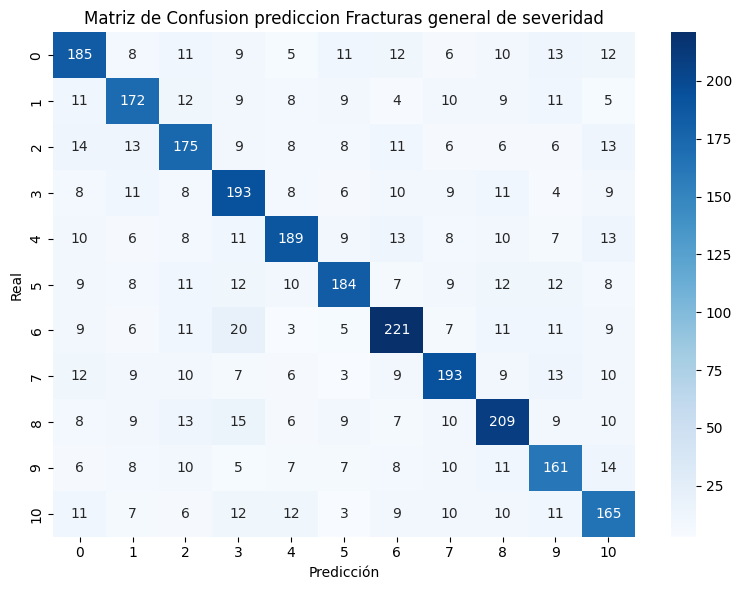

In [22]:
y_true=[]
y_pred=[]
df = pd.read_csv('/content/drive/My Drive/FracPelvis.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(973, 1946):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(hip_fracture_model.predict(np.array(preprocess_image_HD(path)))[1])
y_pred1 = np.argmax(preds, axis=1)
y_true1 = df['clase'].values
y_true.extend(y_true1)
y_pred.extend(y_pred1)

df = pd.read_csv('/content/drive/My Drive/FracAltas.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(1946, 3549):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(altas_fracture_model.predict(np.array(preprocess_image_HD(path)))[1])
y_pred2 = np.argmax(preds, axis=1)
y_true2 = df['clase'].values
# Concatenamos
y_true.extend(y_true2)
y_pred.extend(y_pred2)

df = pd.read_csv('/content/drive/My Drive/FracBajas.csv', header=None)
df.columns = ['clase']
preds = []
for i in range(3549, 5001):
    path = f"/content/drive/My Drive/imagen_prueba{i}.jpg"
    preds.append(bajas_fracture_model.predict(np.array(preprocess_image_HD(path)))[1])
y_pred3 = np.argmax(preds, axis=1)
y_true3 = df['clase'].values
# Concatenamos
y_true.extend(y_true3)
y_pred.extend(y_pred3)
y_true=np.round(y_true*10)
y_pred=np.round(y_pred*10)
# Verificación
same = np.sum(y_true == y_pred)
print(f"Iguales: {same}/{3056} = {same/3056:.2%}")

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusion prediccion Fracturas general de severidad')
plt.tight_layout()
plt.show()